In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycocotools

In [3]:
import json
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np

from matplotlib.patches import Polygon
from pycocotools.coco import COCO

from PIL import Image, ImageDraw

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd

import torchvision.transforms.functional as F
import random

import torch.nn.functional as Fc
#from deeplabv3_plus_ import DeepLabV3Plus
import torch.nn as nn

from torchvision import models
import torch.optim as optim

# DeepLabV3+ Training

## Read Annotations and Draw Mask

In [4]:
def load_coco_annotations(annotations_file, image_dir):
    # Load the COCO annotations file
    with open(annotations_file, 'r') as f:
        data = json.load(f)

    images = {img['id']: img for img in data['images']}
    annotations = data['annotations']

    # Build category mapping
    categories = {cat['id']: cat['name'] for cat in data['categories']}
    print("Categories in dataset:", categories)

    # Initialize category counts
    category_counts = {cat_id: 0 for cat_id in categories.keys()}

    img_paths, labels = [], []
    annotated_img_ids = set()

    # Process annotations and count categories
    for ann in annotations:
        category_counts[ann['category_id']] += 1
        img_id = ann['image_id']
        annotated_img_ids.add(img_id)

    # Print category counts
    print("Category counts:", category_counts)

    # Load images and corresponding annotations
    for img_id in annotated_img_ids:
        img_info = images[img_id]
        img_path = os.path.join(image_dir, img_info['file_name'])
        img_paths.append(img_path)

        # Create an empty segmentation mask
        mask = Image.new('L', (img_info['width'], img_info['height']), 0)  # 'L' for grayscale (0 for background)
        draw = ImageDraw.Draw(mask)

        # Get annotations for the image
        img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]

        # Draw each annotation on the mask
        for ann in img_annotations:
            category_id = ann['category_id']
            segmentation = ann['segmentation']
            for polygon in segmentation:
                points = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                draw.polygon(points, outline=category_id, fill=category_id)

        # Convert mask to numpy array
        mask = np.array(mask)
        labels.append(mask)

    if not img_paths:
        print("No images found.")

    return img_paths, labels, categories

In [7]:
def load_data(train_annotations_file, val_annotations_file, test_annotations_file, image_dirs):
    train_image_dir, val_image_dir, test_image_dir = image_dirs

    train_paths, train_labels, categories = load_coco_annotations(train_annotations_file, train_image_dir)
    val_paths, val_labels, _ = load_coco_annotations(val_annotations_file, val_image_dir)
    test_paths, test_labels, _ = load_coco_annotations(test_annotations_file, test_image_dir)

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels), categories

# Path to dataset and annotations
dataset_dir = '/content/drive/My Drive/FYP/clothing_data'
train_annotations_file = os.path.join(dataset_dir, 'train/_annotations.coco.json')
val_annotations_file = os.path.join(dataset_dir, 'valid/_annotations.coco.json')
test_annotations_file = os.path.join(dataset_dir, 'test/_annotations.coco.json')
image_dirs = (os.path.join(dataset_dir, 'train'), os.path.join(dataset_dir, 'valid'), os.path.join(dataset_dir, 'test'))

# Load annotations and images
(train_image_paths, train_labels), (val_image_paths, val_labels), (test_image_paths, test_labels), categories = load_data(
    train_annotations_file, val_annotations_file, test_annotations_file, image_dirs
)

Categories in dataset: {0: 'ropa', 1: 'coat', 2: 'dress', 3: 'jacket', 4: 'pants', 5: 'shirt', 6: 'shorts', 7: 'skirt', 8: 't-shirt'}
Category counts: {0: 0, 1: 120, 2: 211, 3: 125, 4: 190, 5: 168, 6: 122, 7: 155, 8: 189}
Categories in dataset: {0: 'ropa', 1: 'coat', 2: 'dress', 3: 'jacket', 4: 'pants', 5: 'shirt', 6: 'shorts', 7: 'skirt', 8: 't-shirt'}
Category counts: {0: 0, 1: 38, 2: 53, 3: 48, 4: 67, 5: 55, 6: 36, 7: 55, 8: 56}
Categories in dataset: {0: 'ropa', 1: 'coat', 2: 'dress', 3: 'jacket', 4: 'pants', 5: 'shirt', 6: 'shorts', 7: 'skirt', 8: 't-shirt'}
Category counts: {0: 0, 1: 20, 2: 25, 3: 16, 4: 24, 5: 29, 6: 22, 7: 27, 8: 28}


## Compute Weight for each class to handle imbalance class data

In [ ]:
def compute_class_weights(labels, num_classes):
    # Initialize pixel counts for each class
    pixel_counts = np.zeros(num_classes)

    # Iterate over each mask in the dataset
    for mask in labels:
        # Get unique class IDs and their counts in the mask
        unique, counts = np.unique(mask, return_counts=True)

        for cls, count in zip(unique, counts):
            if cls < num_classes:  # Ignore class ID 0 (background)
                pixel_counts[cls] += count

    # Avoid division by zero by setting counts of zero to 1
    pixel_counts[pixel_counts == 0] = 1

    # Calculate class weights: inverse of frequency
    total_pixels = np.sum(pixel_counts)
    class_weights = total_pixels / (num_classes * pixel_counts)

    # Return as a FloatTensor on the GPU
    return torch.FloatTensor(class_weights).cuda() # REMOVE CUDA WHEN GPU LIMIT HIT!

# Example usage
num_classes = len(categories)  # Make sure categories exclude 0 if it's background
class_weights = compute_class_weights(train_labels, num_classes)

## Load Dataset with Label

In [ ]:
class ConsistentTransform:
    def __init__(self, crop_size=(224, 224)):
        self.crop_size = crop_size

    def __call__(self, image, mask):
        # Resize both (consistent interpolation)
        image = F.resize(image, (256, 256))
        mask = F.resize(mask, (256, 256), interpolation=Image.NEAREST)

        # Random rotation: Generate a single angle and apply to both
        angle = random.uniform(-30, 30)
        image = F.rotate(image, angle)
        mask = F.rotate(mask, angle, interpolation=Image.NEAREST)

        # Random horizontal flip (consistent)
        if random.random() > 0.5:
            image = F.hflip(image)
            mask = F.hflip(mask)

        # Generate a consistent crop (get_params ensures same crop for both)
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.crop_size)
        image = F.crop(image, i, j, h, w)
        mask = F.crop(mask, i, j, h, w)

        # Convert to tensor
        image = F.to_tensor(image)
        mask = torch.tensor(np.array(mask), dtype=torch.long)  # Ensure mask is long tensor

        return image, mask

In [ ]:
class ValTestTransform:
    def __init__(self, crop_size=(224, 224)):
        self.crop_size = crop_size

    def __call__(self, image, mask):
        # Resize both
        image = F.resize(image, (256, 256))
        mask = F.resize(mask, (256, 256), interpolation=Image.NEAREST)

        # Center crop both
        image = F.center_crop(image, self.crop_size)
        mask = F.center_crop(mask, self.crop_size)

        # Convert to tensor
        image = F.to_tensor(image)
        mask = torch.tensor(np.array(mask), dtype=torch.long)  # Ensure mask is a long tensor

        return image, mask

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, masks, transform=None):
        self.image_paths = image_paths
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None  # Skip this sample

        # Load mask
        mask = self.masks[idx]
        mask = Image.fromarray(mask) if isinstance(mask, np.ndarray) else mask

        # Apply transformations (if provided)
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

In [ ]:
# Now when using DataLoader, we need to handle the case where None is returned
def collate_fn(batch):
    # Filter out any samples that returned None
    batch = [item for item in batch if item is not None]

    images, masks = zip(*batch)

    # Ensure all items are tensors
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)

    return images, masks

In [ ]:
# Usage in your Dataset
train_transform = ConsistentTransform()

val_test_transform = ValTestTransform(crop_size=(224, 224))

# Prepare datasets with oversampled data
train_dataset = CustomDataset(
    image_paths=train_image_paths,
    masks=train_labels,
    transform=train_transform
)

val_dataset = CustomDataset(
    image_paths=val_image_paths,
    masks=val_labels,
    transform=val_test_transform
)

test_dataset = CustomDataset(
    image_paths=test_image_paths,
    masks=test_labels,
    transform=val_test_transform
)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Loss Calculation Function

In [ ]:
def calculate_iou(preds, labels, num_classes):
    iou = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union > 0:
            iou.append(intersection / union)
    return sum(iou) / len(iou)

def dice_loss(pred, target, smooth=1):
    pred = Fc.softmax(pred, dim=1)  # Convert logits to probabilities
    target_one_hot = Fc.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    # Compute intersection and union
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    # Dice coefficient
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(outputs, labels, class_weights):
    # Ensure weights are on the same device as model inputs
    class_weights = class_weights.to(device)

    # Weighted Cross-Entropy Loss
    ce_loss = Fc.cross_entropy(outputs, labels, weight=class_weights)

    # Dice Loss
    dice = dice_loss(outputs, labels)

    return ce_loss + dice

## Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9
model = DeepLabV3Plus(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def visualize_training_samples(inputs, labels, predictions, num_samples=2):
    """
    Visualize a few samples of the input, labels, and predictions.
    """
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    for i in range(min(num_samples, inputs.shape[0])):
        input_image = np.transpose(inputs[i], (1, 2, 0))  # Convert to HWC for display
        label_image = labels[i]  # Should be (H, W)
        pred_image = predictions[i]  # Should be (H, W)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(label_image, cmap="nipy_spectral")  # Ensure categorical visualization
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_image, cmap="nipy_spectral")  # Ensure categorical visualization
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

In [ ]:
# Function to visualize and save images
def save_visualization(images, labels, preds, epoch, batch_idx, output_dir="visualizations"):
    os.makedirs(output_dir, exist_ok=True)
    batch_size = images.size(0)

    for i in range(batch_size):
        input_image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
        label_image = labels[i].cpu().numpy()
        pred_image = preds[i].cpu().numpy()

        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(input_image)
        plt.axis('off')

        # Ground Truth
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(label_image, cmap='gray')
        plt.axis('off')

        # Model Prediction
        plt.subplot(1, 3, 3)
        plt.title("Model Prediction")
        plt.imshow(pred_image, cmap='gray')
        plt.axis('off')

        # Save figure
        save_path = os.path.join(output_dir, f"epoch_{epoch+1}_batch_{batch_idx+1}_sample_{i+1}.png")
        plt.savefig(save_path)
        plt.close()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, visualize_every_batch=False, visualize_every_epoch=10):
    # Initialize a dictionary to store metrics for each epoch
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'iou_loss': [],
        'dice_loss': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        epoch_iou, epoch_dice_loss = 0.0, 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            try:
                # Move inputs to the device
                images, labels = images.to(device), labels.to(device)

                # Preprocess labels
                labels = labels.squeeze(1).long()  # Ensure correct shape and type

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)

                # Resize model output to match label size
                outputs = Fc.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)
                outputs_prob = Fc.softmax(outputs, dim=1)
                preds = torch.argmax(outputs_prob, dim=1)

                # Compute loss
                loss = combined_loss(outputs, labels, class_weights)
                loss.backward()
                optimizer.step()

                # Update training statistics
                running_loss += loss.item() * images.size(0)
                correct_train += torch.sum(preds == labels).item()
                total_train += labels.numel()

                # Compute batch-level metrics
                batch_iou = calculate_iou(preds, labels, num_classes)
                batch_dice_loss = dice_loss(outputs, labels).item()
                epoch_iou += batch_iou
                epoch_dice_loss += batch_dice_loss

                # Visualize predictions for the first batch in each epoch
                # if visualize_every_batch:
                #     visualize_training_samples(images, labels, preds)

                # Save visualizations every `visualize_every_epoch`
                # if (epoch + 1) % visualize_every_epoch == 0:
                #     save_visualization(images, labels, preds, epoch, batch_idx)

                # Print per-batch metrics
                # print(f"Batch {batch_idx+1}: Loss = {loss.item():.4f}, IoU = {batch_iou:.4f}, Dice Loss = {batch_dice_loss:.4f}")

            except Exception as e:
                print(f"Skipping batch {batch_idx+1}: {e}")
                continue

        # Compute epoch metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        avg_iou = epoch_iou / len(train_loader)
        avg_dice_loss = epoch_dice_loss / len(train_loader)

        # Store metrics in the history dictionary
        metrics_history['train_loss'].append(train_loss)
        metrics_history['train_accuracy'].append(train_acc)
        metrics_history['iou_loss'].append(avg_iou)
        metrics_history['dice_loss'].append(avg_dice_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, IoU: {avg_iou:.4f}, Dice Loss: {avg_dice_loss:.4f}")

    return metrics_history

# Train the model and store metrics
metrics_history = train_model(model, train_loader, val_loader, optimizer, num_epochs=50)

Epoch 1/50: Train Loss: 2.7096, Train Accuracy: 0.3993, IoU: 0.1195, Dice Loss: 0.9139
Epoch 2/50: Train Loss: 2.0563, Train Accuracy: 0.6791, IoU: 0.2437, Dice Loss: 0.8605
Epoch 3/50: Train Loss: 1.7137, Train Accuracy: 0.7901, IoU: 0.3558, Dice Loss: 0.8334
Epoch 4/50: Train Loss: 1.4538, Train Accuracy: 0.8268, IoU: 0.4309, Dice Loss: 0.8139
Epoch 5/50: Train Loss: 1.2990, Train Accuracy: 0.8562, IoU: 0.4921, Dice Loss: 0.7986
Epoch 6/50: Train Loss: 1.2605, Train Accuracy: 0.8661, IoU: 0.5144, Dice Loss: 0.7904
Epoch 7/50: Train Loss: 1.1682, Train Accuracy: 0.8739, IoU: 0.5285, Dice Loss: 0.7848
Epoch 8/50: Train Loss: 1.1358, Train Accuracy: 0.8821, IoU: 0.5590, Dice Loss: 0.7796
Epoch 9/50: Train Loss: 1.0899, Train Accuracy: 0.8937, IoU: 0.5831, Dice Loss: 0.7738
Epoch 10/50: Train Loss: 1.0255, Train Accuracy: 0.8987, IoU: 0.6038, Dice Loss: 0.7686
Epoch 11/50: Train Loss: 1.0014, Train Accuracy: 0.9047, IoU: 0.6243, Dice Loss: 0.7636
Epoch 12/50: Train Loss: 0.9492, Train Ac

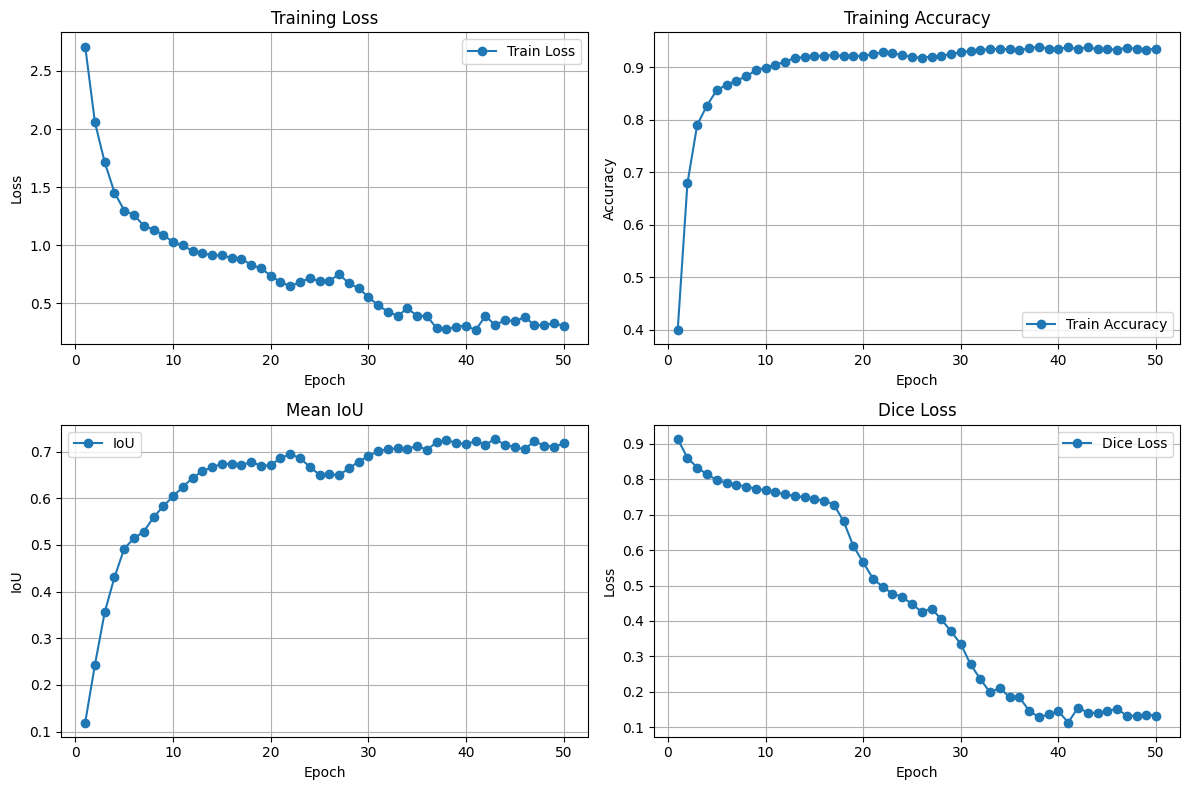

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['train_loss']) + 1)

    # Plot Training Loss
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics_history['train_loss'], marker='o', label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics_history['train_accuracy'], marker='o', label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot IoU Loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics_history['iou_loss'], marker='o', label='IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.grid(True)
    plt.legend()

    # Plot Dice Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics_history['dice_loss'], marker='o', label='Dice Loss')
    plt.title('Dice Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(metrics_history)

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/FYP/clothing_data/segmentation_model.pth")

## Evaluation

In [ ]:
def evaluate_model(model, test_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    corrects = 0
    total = 0
    iou_sum = 0.0
    dice_sum = 0.0

    batch_count = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            print(f"Processing batch {batch_idx + 1}")
            try:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1).long()

                # Forward pass
                outputs = model(images)
                outputs = Fc.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=False)

                # Compute combined loss
                loss = combined_loss(outputs, labels, class_weights)
                test_loss += loss.item() * images.size(0)

                # Predictions
                preds = torch.argmax(outputs, dim=1)

                # IoU
                iou_batch = calculate_iou(preds, labels, num_classes)
                iou_sum += iou_batch

                # Dice Loss
                dice_batch = dice_loss(outputs, labels).item()
                dice_sum += dice_batch

                # Accuracy
                corrects += torch.sum(preds == labels).item()
                total += labels.numel()

                batch_count += 1

            except Exception as e:
                print(f"Skipping batch {batch_idx + 1} due to error: {e}")
                continue

    # Final Metrics
    if batch_count > 0:
        test_loss /= len(test_loader.dataset)
        test_acc = corrects / float(total)
        avg_iou = iou_sum / batch_count
        avg_dice_loss = dice_sum / batch_count

        print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
        print(f"Average IoU: {avg_iou:.4f}, Average Dice Loss: {avg_dice_loss:.4f}")
    else:
        print("No valid batches processed!")

# Call the function
evaluate_model(model, test_loader, num_classes=9)

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Test Loss: 3.0203, Accuracy: 0.8863
Average IoU: 0.4410, Average Dice Loss: 0.3361


Input image shape (raw): (3, 224, 224)
Input image shape (processed): (224, 224, 3)
Label image shape: (224, 224)
Prediction image shape (upsampled): (224, 224)


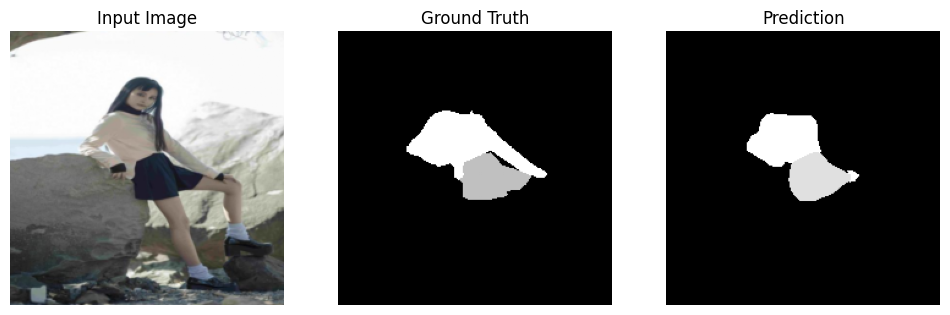

Input image shape (raw): (3, 224, 224)
Input image shape (processed): (224, 224, 3)
Label image shape: (224, 224)
Prediction image shape (upsampled): (224, 224)


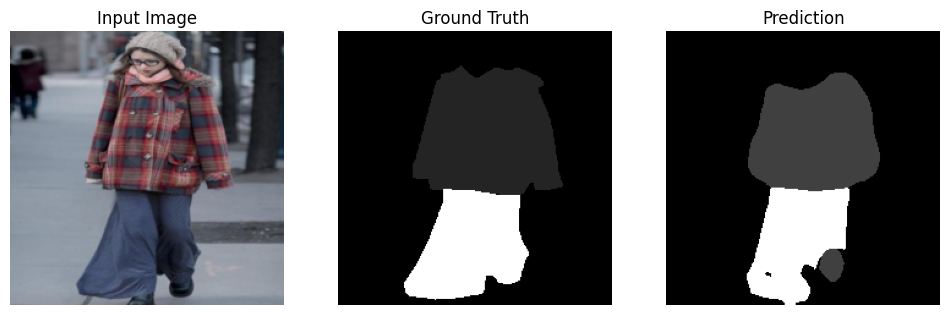

Input image shape (raw): (3, 224, 224)
Input image shape (processed): (224, 224, 3)
Label image shape: (224, 224)
Prediction image shape (upsampled): (224, 224)


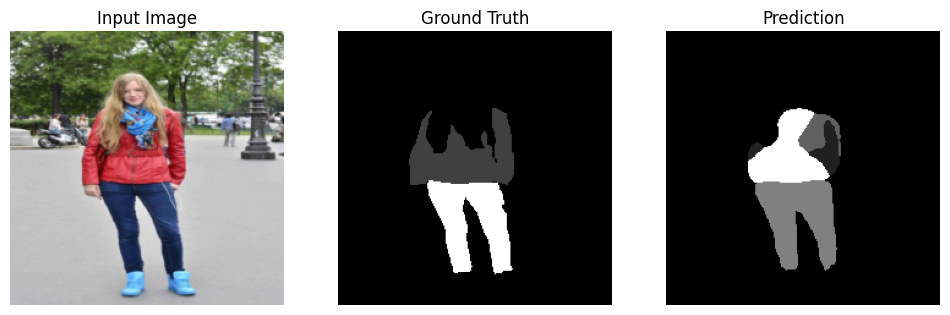

Input image shape (raw): (3, 224, 224)
Input image shape (processed): (224, 224, 3)
Label image shape: (224, 224)
Prediction image shape (upsampled): (224, 224)


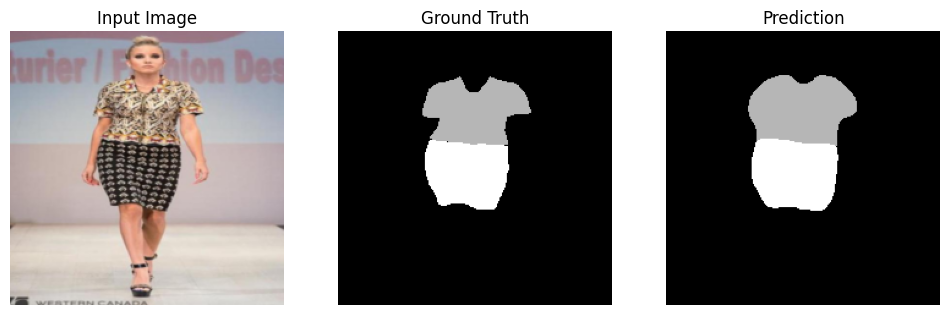

Input image shape (raw): (3, 224, 224)
Input image shape (processed): (224, 224, 3)
Label image shape: (224, 224)
Prediction image shape (upsampled): (224, 224)


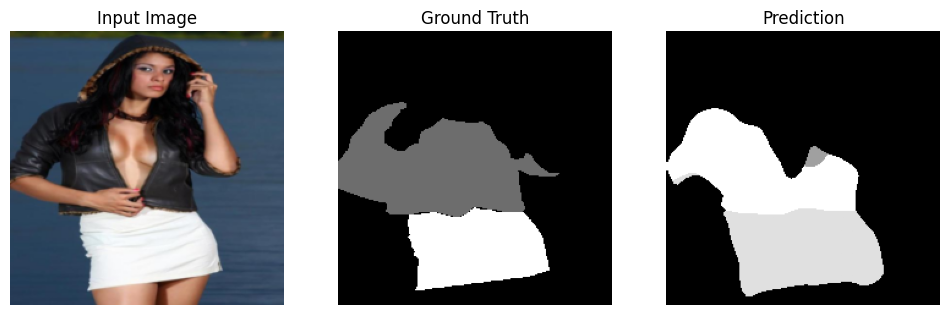

In [ ]:
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    images_shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Upsample predictions to match label size
            outputs = Fc.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=False)
            preds = torch.argmax(Fc.softmax(outputs, dim=1), dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                # Process input image for visualization
                input_image = images[i].cpu().numpy()
                print(f"Input image shape (raw): {input_image.shape}")

                # Ensure input image shape is valid for visualization
                if input_image.shape[0] == 1:  # Grayscale with channel dimension
                    input_image = input_image.squeeze(0)  # Remove channel dimension
                else:
                    input_image = np.transpose(input_image, (1, 2, 0))  # Convert to (H, W, C)
                print(f"Input image shape (processed): {input_image.shape}")

                # Process label and prediction images
                label_image = labels[i].squeeze(0).cpu().numpy()  # Remove extra channel
                pred_image = preds[i].cpu().numpy()  # Prediction is already (H, W)

                print(f"Label image shape: {label_image.shape}")
                print(f"Prediction image shape (upsampled): {pred_image.shape}")

                # Visualize input, label, and prediction
                plt.figure(figsize=(12, 4))

                # Input Image
                plt.subplot(1, 3, 1)
                plt.title("Input Image")
                plt.imshow(input_image, cmap='gray' if input_image.ndim == 2 else None)
                plt.axis('off')

                # Ground Truth
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(label_image, cmap='gray')
                plt.axis('off')

                # Prediction
                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred_image, cmap='gray')
                plt.axis('off')

                plt.show()
                images_shown += 1

# Call the function to visualize
visualize_predictions(model, test_loader, num_images=5)